# TD3算法实现

引包

In [9]:
# import pytorch things
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import other utilities
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from IPython.display import clear_output

# simulation environment
import gym

参数设置

In [10]:
class Config:
  def __init__(self):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"  # 检测GPU
    self.state_dim = 3
    self.action_dim = 1
    self.hidden1_dim = 400
    self.hidden2_dim = 300
    self.actor_lr = 0.001
    self.critic_lr = 0.001
    self.gamma = 0.99 # reward discount
    self.beta = 0.5 # learning rate for the actor
    self.tau = 0.005 # soft update
    self.target_update_interval = 5 # target network update interval
    self.noise_sigma = 0.2 # noise follow normal distribution
    self.noise_clip = 0.5 # clip noise to prevent too large action
    self.batch_size = 64
    self.memory_size = 100000
    self.train_eps = 1000

经验回放池

In [11]:
class ReplayBuffer:
  
  # 经验回放池的数据结构是一个循环队列
  
  def __init__(self, capacity):
    self.capacity = capacity # 经验回放的容量
    self.buffer = [] # 经验回放的缓存
    self.position = 0 # 缓存指针

  def push(self, state, action, reward, next_state, done):
    if len(self.buffer) < self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state, action, reward, next_state, done)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    batch = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*batch)
    return state, action, reward, next_state, done

  def __len__(self):
    return len(self.buffer)

定义Actor和Critic网络

In [12]:
class Actor(nn.Module):
  def __init__(self, state_dim, action_dim, hidden1_dim, hidden2_dim, init_w=3e-3):
    super(Actor, self).__init__()
    self.fc1 = nn.Linear(state_dim, hidden1_dim)
    self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
    self.fc3 = nn.Linear(hidden2_dim, action_dim)

    # initialize the weights and bias
    self.fc3.weight.data.uniform_(-init_w, init_w)
    self.fc3.bias.data.uniform_(-init_w, init_w)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    x = torch.tanh(self.fc3(x)) # action output is in [-1, 1]
    return x
  
class Critic(nn.Module):
  def __init__(self, state_dim, action_dim, hidden1_dim, hidden2_dim, init_w=3e-3):
    super(Critic, self).__init__()
    self.fc1 = nn.Linear(state_dim + action_dim, hidden1_dim)
    self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
    self.fc3 = nn.Linear(hidden2_dim, 1)

    # initialize the weights and bias
    self.fc3.weight.data.uniform_(-init_w, init_w)
    self.fc3.bias.data.uniform_(-init_w, init_w)

  def forward(self, state, action):
    x = torch.cat([state, action], 1) # concatenate the state and action
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

TD3算法本体

In [13]:
class TD3:
  def __init__(self, config):
    self.config = config

    # initialize actor and critic networks
    self.actor = Actor(config.state_dim, config.action_dim, config.hidden1_dim, config.hidden2_dim).to(config.device)
    self.actor_target = Actor(config.state_dim, config.action_dim, config.hidden1_dim, config.hidden2_dim).to(config.device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config.actor_lr)

    self.critic1 = Critic(config.state_dim, config.action_dim, config.hidden1_dim, config.hidden2_dim).to(config.device)
    self.critic1_target = Critic(config.state_dim, config.action_dim, config.hidden1_dim, config.hidden2_dim).to(config.device)
    self.critic1_target.load_state_dict(self.critic1.state_dict())
    self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=config.critic_lr)

    self.critic2 = Critic(config.state_dim, config.action_dim, config.hidden1_dim, config.hidden2_dim).to(config.device)
    self.critic2_target = Critic(config.state_dim, config.action_dim, config.hidden1_dim, config.hidden2_dim).to(config.device)
    self.critic2_target.load_state_dict(self.critic2.state_dict())
    self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=config.critic_lr)

    # initialize the replay buffer and other hyperparameters
    self.memory = ReplayBuffer(config.memory_size)
    self.batch_size = config.batch_size
    self.gamma = config.gamma
    self.beta = config.beta
    self.tau = config.tau
    self.noise_sigma = config.noise_sigma
    self.noise_clip = config.noise_clip
    self.target_update_interval = config.target_update_interval

  def select_action(self, state):
    state = torch.FloatTensor(state).to(self.config.device).unsqueeze(0)
    action = self.actor(state)
    action = action.cpu().data.numpy().flatten()
    return action
  
  def update(self, soft_update_flag=False):
    # check if the replay buffer contains enough samples
    if len(self.memory) < self.batch_size:
      return
    
    # sample a batch of transitions
    state, action, reward, next_state, done = self.memory.sample(self.batch_size)
    state = torch.FloatTensor(state).to(self.config.device)
    action = torch.FloatTensor(action).to(self.config.device)
    reward = torch.FloatTensor(reward).to(self.config.device)
    next_state = torch.FloatTensor(next_state).to(self.config.device)
    done = torch.FloatTensor(done).to(self.config.device)

    # let the target actor predict the next action
    target_action = self.actor_target(next_state) + torch.clamp(torch.FloatTensor(np.random.normal(0, self.noise_sigma, size=self.config.action_dim)), -self.noise_clip, self.noise_clip)

    # let the two target critc networks predict the Q value
    target_q_value1 = self.critic1_target(next_state, target_action)
    target_q_value2 = self.critic2_target(next_state, target_action)

    # calculate TD target
    target_td_value = reward + self.gamma * torch.min(target_q_value1, target_q_value2)

    # let the two critic networks predict the Q value
    current_q_value1 = self.critic1(state, action)
    current_q_value2 = self.critic2(state, action)

    # update the critic networks
    critic1_loss = F.mse_loss(current_q_value1, target_td_value.detach())
    self.critic1_optimizer.zero_grad()
    critic1_loss.backward()
    self.critic1_optimizer.step()

    critic2_loss = F.mse_loss(current_q_value2, target_td_value.detach())
    self.critic2_optimizer.zero_grad()
    critic2_loss.backward()
    self.critic2_optimizer.step()

    # every target_update_interval steps, update the actor network and the 3 target networks
    if soft_update_flag:
      # update the actor network
      actor_loss = - self.beta * self.critic1(state, self.actor(state)).mean()
      self.actor_optimizer.zero_grad()
      actor_loss.backward()
      self.actor_optimizer.step()

      # update the target networks
      for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
      for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
      for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


展示reward相关画图函数

In [14]:
def plot_rewards_live(rewards):
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Total Reward')
    plt.plot(pd.Series(rewards).rolling(window=100).mean(), label='Moving Average Reward', color='orange')
    plt.title('Cumulative Reward and Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

def plot_rewards(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Total Reward')
    plt.plot(pd.Series(rewards).rolling(window=100).mean(), label='Moving Average Reward', color='orange')
    plt.title('Cumulative Reward and Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

TD3训练过程

In [15]:
def train(agent, env, config):
  total_reward = []

  for eps in range(config.train_eps):
    # reset environment and get initial state
    state = env.reset()
    state = state[0] # gym returns a tuple, we only need the first element
    episode_reward = 0
    done = False

    # start training
    k = 0
    while not done:
      action = agent.select_action(state)
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      reward = np.array([reward]) # convert to numpy array to match the type of state and action
      done = np.array([done]) # convert to numpy array to match the type of state and action
      agent.memory.push(state, action, reward, next_state, done) # store the transition in memory
      episode_reward += reward
      state = next_state
      if (k % config.target_update_interval) == 0:
        agent.update(soft_update_flag=True)
      else:
        agent.update(soft_update_flag=False)
      k += 1

    total_reward.append(episode_reward)
    # plot_rewards_live(total_reward)
    print(f"Episode: {eps+1}, reward: {episode_reward}")


  return total_reward

主函数

/usr/anaconda3/envs/rl-playground/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, reward: [-1314.97597381]
Episode: 2, reward: [-1392.06804579]
Episode: 3, reward: [-1694.98138478]
Episode: 4, reward: [-1150.01616559]
Episode: 5, reward: [-1157.04293162]
Episode: 6, reward: [-1389.70028532]
Episode: 7, reward: [-1387.25796566]
Episode: 8, reward: [-1221.33073482]
Episode: 9, reward: [-1330.31840006]
Episode: 10, reward: [-1064.1076128]
Episode: 11, reward: [-1383.17356925]
Episode: 12, reward: [-1055.00015896]
Episode: 13, reward: [-1390.56683151]
Episode: 14, reward: [-1383.63892253]
Episode: 15, reward: [-1775.95867473]
Episode: 16, reward: [-1384.00557006]
Episode: 17, reward: [-1205.55491961]
Episode: 18, reward: [-1820.20470581]
Episode: 19, reward: [-1372.94107606]
Episode: 20, reward: [-1537.95159641]
Episode: 21, reward: [-1845.13398125]
Episode: 22, reward: [-1388.08307589]
Episode: 23, reward: [-724.09593444]
Episode: 24, reward: [-1452.0790233]
Episode: 25, reward: [-1661.64550077]
Episode: 26, reward: [-1734.32149097]
Episode: 27, reward: [-1

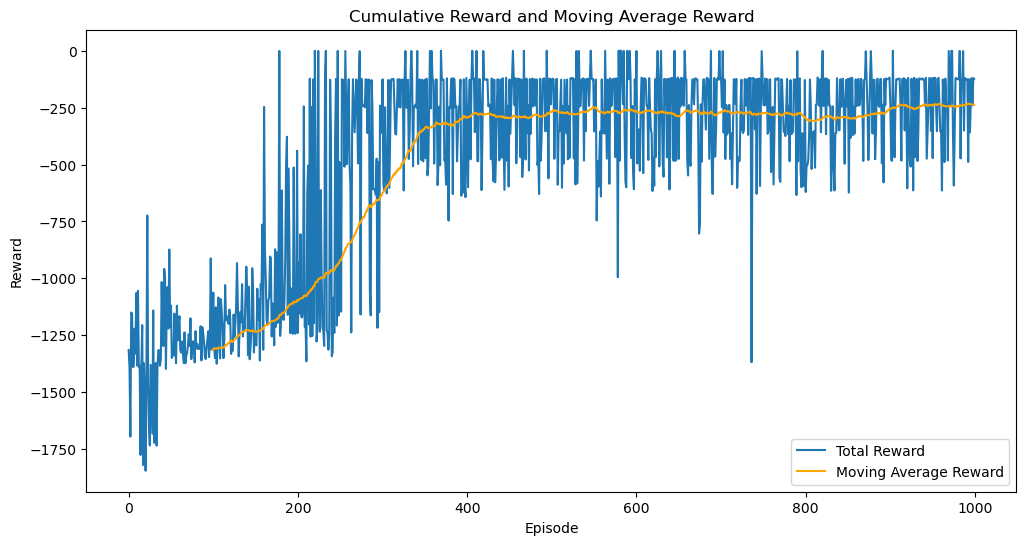

In [16]:
if __name__ == "__main__":
    config = Config()
    env = gym.make("Pendulum-v1")
    agent = TD3(config)
    rewards = train(agent, env, config)
    plot_rewards(rewards)